In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd

Using TensorFlow backend.


In [2]:
# Define a function to re-shape the data
# convert series to supervised learning
#Frame a time series as a supervised learning dataset.
#Arguments:
#data: Sequence of observations as a list or NumPy array.
#n_in: Number of lag observations as input (X).
#n_out: Number of observations as output (y).
#dropnan: Boolean whether or not to drop rows with NaN values.
#Returns:Pandas DataFrame of series framed for supervised learning.
    
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
data=pd.read_excel('../../../Data/Model_Data_Rev1.xlsx')
data.dropna(inplace=True, how='any')
data.set_index(['Date'], inplace=True)
data=data[['Offshore_Utilization_Rate', 'Active_Rig_Count',
       'Land_Rig_Active_Count', 'Crude_Price_2010_USD',
       'Adjusted_Nat_Gas_Price_2010', 'World_Oil_Cunsump',
       'World_Oil_Production']]

In [4]:
values = data.values

In [5]:
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [6]:
reframed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.786283,0.872449,0.889263,0.391202,0.066360,0.000000,0.000000,0.777806,0.897230,0.917341,0.329032,0.062566,0.000000,0.000000
2,0.777806,0.897230,0.917341,0.329032,0.062566,0.000000,0.000000,0.703314,0.852405,0.875169,0.256137,0.062220,0.046617,0.055106
3,0.703314,0.852405,0.875169,0.256137,0.062220,0.046617,0.055106,0.595941,0.716837,0.738944,0.131881,0.061559,0.046617,0.055106
4,0.595941,0.716837,0.738944,0.131881,0.061559,0.046617,0.055106,0.423581,0.555758,0.581047,0.085966,0.057885,0.046617,0.055106
5,0.423581,0.555758,0.581047,0.085966,0.057885,0.046617,0.055106,0.282815,0.360058,0.381940,0.090574,0.055694,0.046617,0.055106


In [7]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)',
       'var5(t)', 'var6(t)', 'var7(t)'],
      dtype='object')

In [8]:
reframed.drop(reframed.columns[[-1,-2,-3,-4,-5,-6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.786283   0.872449   0.889263   0.391202   0.066360   0.000000   
2   0.777806   0.897230   0.917341   0.329032   0.062566   0.000000   
3   0.703314   0.852405   0.875169   0.256137   0.062220   0.046617   
4   0.595941   0.716837   0.738944   0.131881   0.061559   0.046617   
5   0.423581   0.555758   0.581047   0.085966   0.057885   0.046617   

   var7(t-1)   var1(t)  
1   0.000000  0.777806  
2   0.000000  0.703314  
3   0.055106  0.595941  
4   0.055106  0.423581  
5   0.055106  0.282815  


In [9]:
reframed=reframed.rename(columns={
    'var1(t-1)':'Offshore_Utilization_Rate (t-1)', 
    'var2(t-1)':'Active_Rig_Count (t-1)', 
    'var3(t-1)':'Land_Rig_Active_Count (t-1)', 
    'var4(t-1)':'Crude_Price_2010_USD (t-1)', 
    'var5(t-1)':'Adjusted_Nat_Gas_Price_2010 (t-1)',
    'var6(t-1)':'World_Oil_Cunsump (t-1)', 
    'var7(t-1)':'World_Oil_Production (t-1)', 
    'var1(t)':'Offshore_Utilization_Rate'
})

In [10]:
reframed.shape

(407, 8)

In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 300 # how many data points to be used as training data, rest goes to test (approximately 25% as test)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300, 1, 7) (300,) (107, 1, 7) (107,)


Train on 300 samples, validate on 107 samples
Epoch 1/200
 - 1s - loss: 0.6402 - mse: 0.4452 - val_loss: 0.3766 - val_mse: 0.2135
Epoch 2/200
 - 0s - loss: 0.5933 - mse: 0.3841 - val_loss: 0.3343 - val_mse: 0.1658
Epoch 3/200
 - 0s - loss: 0.5452 - mse: 0.3264 - val_loss: 0.2945 - val_mse: 0.1249
Epoch 4/200
 - 0s - loss: 0.4957 - mse: 0.2720 - val_loss: 0.2590 - val_mse: 0.0912
Epoch 5/200
 - 0s - loss: 0.4444 - mse: 0.2208 - val_loss: 0.2284 - val_mse: 0.0657
Epoch 6/200
 - 0s - loss: 0.3913 - mse: 0.1733 - val_loss: 0.2036 - val_mse: 0.0498
Epoch 7/200
 - 0s - loss: 0.3353 - mse: 0.1299 - val_loss: 0.1858 - val_mse: 0.0456
Epoch 8/200
 - 0s - loss: 0.2772 - mse: 0.0919 - val_loss: 0.1819 - val_mse: 0.0555
Epoch 9/200
 - 0s - loss: 0.2216 - mse: 0.0610 - val_loss: 0.2236 - val_mse: 0.0794
Epoch 10/200
 - 0s - loss: 0.1754 - mse: 0.0408 - val_loss: 0.2874 - val_mse: 0.1087
Epoch 11/200
 - 0s - loss: 0.1395 - mse: 0.0291 - val_loss: 0.3411 - val_mse: 0.1392
Epoch 12/200
 - 0s - loss: 0

Epoch 97/200
 - 0s - loss: 0.0297 - mse: 0.0019 - val_loss: 0.0647 - val_mse: 0.0058
Epoch 98/200
 - 0s - loss: 0.0290 - mse: 0.0019 - val_loss: 0.0630 - val_mse: 0.0055
Epoch 99/200
 - 0s - loss: 0.0286 - mse: 0.0018 - val_loss: 0.0618 - val_mse: 0.0052
Epoch 100/200
 - 0s - loss: 0.0280 - mse: 0.0017 - val_loss: 0.0599 - val_mse: 0.0049
Epoch 101/200
 - 0s - loss: 0.0274 - mse: 0.0017 - val_loss: 0.0584 - val_mse: 0.0046
Epoch 102/200
 - 0s - loss: 0.0270 - mse: 0.0016 - val_loss: 0.0572 - val_mse: 0.0044
Epoch 103/200
 - 0s - loss: 0.0266 - mse: 0.0016 - val_loss: 0.0562 - val_mse: 0.0042
Epoch 104/200
 - 0s - loss: 0.0263 - mse: 0.0015 - val_loss: 0.0549 - val_mse: 0.0040
Epoch 105/200
 - 0s - loss: 0.0261 - mse: 0.0015 - val_loss: 0.0533 - val_mse: 0.0039
Epoch 106/200
 - 0s - loss: 0.0257 - mse: 0.0015 - val_loss: 0.0531 - val_mse: 0.0038
Epoch 107/200
 - 0s - loss: 0.0255 - mse: 0.0015 - val_loss: 0.0518 - val_mse: 0.0036
Epoch 108/200
 - 0s - loss: 0.0253 - mse: 0.0014 - val_lo

Epoch 192/200
 - 0s - loss: 0.0211 - mse: 9.3559e-04 - val_loss: 0.0396 - val_mse: 0.0022
Epoch 193/200
 - 0s - loss: 0.0219 - mse: 9.8746e-04 - val_loss: 0.0382 - val_mse: 0.0021
Epoch 194/200
 - 0s - loss: 0.0211 - mse: 9.3307e-04 - val_loss: 0.0392 - val_mse: 0.0022
Epoch 195/200
 - 0s - loss: 0.0221 - mse: 0.0010 - val_loss: 0.0380 - val_mse: 0.0021
Epoch 196/200
 - 0s - loss: 0.0211 - mse: 9.3446e-04 - val_loss: 0.0395 - val_mse: 0.0022
Epoch 197/200
 - 0s - loss: 0.0218 - mse: 9.8383e-04 - val_loss: 0.0381 - val_mse: 0.0021
Epoch 198/200
 - 0s - loss: 0.0210 - mse: 9.3147e-04 - val_loss: 0.0392 - val_mse: 0.0022
Epoch 199/200
 - 0s - loss: 0.0219 - mse: 9.9585e-04 - val_loss: 0.0378 - val_mse: 0.0021
Epoch 200/200
 - 0s - loss: 0.0211 - mse: 9.3267e-04 - val_loss: 0.0390 - val_mse: 0.0021


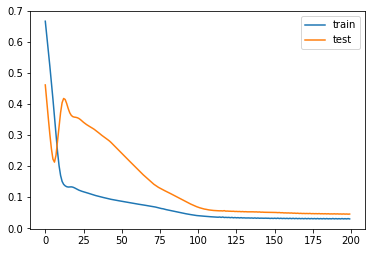

In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse'])
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot([sqrt(i) for i in history.history['mse']], label='train')
pyplot.plot([sqrt(i) for i in history.history['val_mse']], label='test')
pyplot.legend()
pyplot.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.799


In [14]:
model.save('mv_LTSM_model.h5')

In [15]:
inv_yhat

array([75.47566 , 74.56895 , 73.07844 , 73.67354 , 76.28104 , 77.76566 ,
       77.72009 , 78.54051 , 79.023056, 79.17141 , 79.74534 , 80.10872 ,
       80.49153 , 81.338264, 80.84583 , 80.197014, 81.231064, 82.04304 ,
       82.725235, 83.26348 , 83.72151 , 83.66143 , 84.4145  , 84.03889 ,
       83.91635 , 84.95631 , 85.29332 , 85.48687 , 85.7664  , 86.2964  ,
       86.80795 , 86.552055, 86.60939 , 86.7103  , 87.30431 , 87.53277 ,
       87.08628 , 87.047195, 86.22289 , 85.75558 , 85.88552 , 86.32637 ,
       84.97648 , 84.20545 , 84.03076 , 83.21093 , 82.229385, 81.613   ,
       80.98101 , 80.134056, 79.15431 , 77.987076, 78.42175 , 77.649216,
       76.73898 , 75.46612 , 74.356766, 72.52545 , 70.97866 , 70.05304 ,
       68.91217 , 67.982635, 65.957634, 65.173355, 65.220245, 64.5842  ,
       63.72744 , 62.379272, 61.89414 , 60.879845, 60.297993, 59.876877,
       58.814064, 58.28326 , 57.755802, 57.95858 , 58.422085, 58.90726 ,
       58.9658  , 59.060257, 59.770382, 59.61896 , 

In [16]:
inv_y

array([75.44    , 74.27    , 75.07    , 77.47    , 78.4     , 78.44    ,
       79.46    , 80.15    , 80.71    , 81.36    , 81.82    , 82.09    ,
       82.8     , 82.63999 , 82.25    , 82.88    , 83.16001 , 83.89    ,
       84.69    , 85.11001 , 84.98999 , 85.68    , 85.31    , 85.2     ,
       86.100006, 86.62999 , 87.01    , 86.99    , 87.11    , 87.55001 ,
       87.44    , 87.57    , 87.740005, 88.31    , 88.56    , 88.2     ,
       88.14001 , 87.62    , 87.27    , 87.26    , 87.399994, 86.100006,
       85.45    , 85.56    , 84.87    , 83.97    , 83.43    , 82.87    ,
       82.04    , 80.92    , 79.270004, 79.15    , 77.95    , 76.78    ,
       75.46    , 74.4     , 72.6     , 70.83    , 69.7     , 68.42    ,
       67.31    , 64.93    , 63.83    , 63.49    , 62.49    , 61.37    ,
       59.680004, 59.24    , 58.1     , 57.43    , 56.929996, 55.75    ,
       55.169994, 54.84    , 55.34    , 55.87    , 56.32    , 56.449997,
       56.820004, 57.83    , 57.65    , 57.69    , 

In [17]:
df=pd.DataFrame({'predict':inv_yhat,'actual':inv_y})

In [36]:
df.to_csv('time_series_comp.csv', index=True)

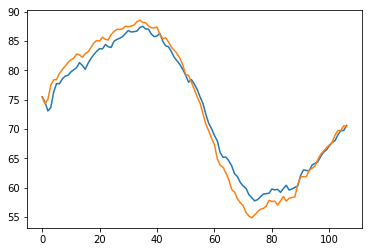

In [18]:
pyplot.plot(df['predict'])
pyplot.plot(df['actual'])

In [21]:
# make prediction for Nov 2019
new_data=data.tail(1)

In [23]:
new_data=new_data.values

In [24]:
new_data

array([[  70.4       , 2123.        , 1588.74      ,   49.24      ,
          49.24094515, 8358.        , 8527.        ]])

In [31]:
new_data = scaler.fit_transform(new_data)

In [32]:
new_X = new_data.reshape((new_data.shape[0], 1, new_data.shape[1]))

In [33]:
y_new = model.predict(new_X)

In [34]:
new_X = new_X.reshape((new_X.shape[0], new_X.shape[2]))
# invert scaling for forecast
inv_ynew = concatenate((y_new, new_X[:, 1:]), axis=1)
inv_ynew = scaler.inverse_transform(inv_ynew)
inv_ynew = inv_ynew[:,0]

In [35]:
inv_ynew

array([70.49436067])